<b> Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<b>Random seed set

In [2]:
np.random.seed(33)

<b> Dataset Loading

In [3]:
df = yf.download('DIS', start='2018-01-01', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


<b>Dataset Overview

In [4]:
print("Shape:",df.shape, end="\n\n")
print("Head:\n", df.head())
print(f"\nNull Values:\n{df.isnull().sum()}", end="\n\n")
print(df.info(), end="\n\n")
print(f"Unique Values:\n{df.nunique()}", end="\n\n")
print(f"Describe():\n{df.describe()}")

Shape: (1259, 6)

Head:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  108.949997  111.809998  108.559998  111.800003  108.726067   
2018-01-03  112.190002  113.190002  111.449997  112.279999  109.192856   
2018-01-04  112.949997  113.000000  111.629997  112.230003  109.144241   
2018-01-05  112.680000  112.680000  111.239998  111.620003  108.551003   
2018-01-08  110.889999  111.279999  109.540001  110.019997  106.994980   

              Volume  
Date                  
2018-01-02  11014300  
2018-01-03   9237900  
2018-01-04   7417400  
2018-01-05   6008300  
2018-01-08   8052600  

Null Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------  

<b> Examining Distribution of Day

In [5]:
df['date'] = pd.to_datetime(df.index)

In [6]:
df['day'] = df['date'].dt.weekday

In [7]:
df['day_of_week'] = df['date'].dt.day_name()

In [8]:
df['day_of_week'].value_counts()

day_of_week
Tuesday      259
Wednesday    257
Thursday     255
Friday       252
Monday       236
Name: count, dtype: int64

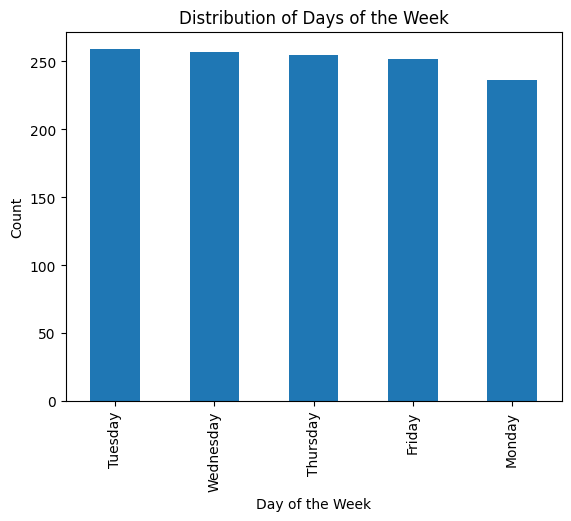

In [9]:
df['day_of_week'].value_counts().plot(kind='bar')

# Set plot labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Distribution of Days of the Week')

# Display the plot
plt.show()

<b> Closing Stock

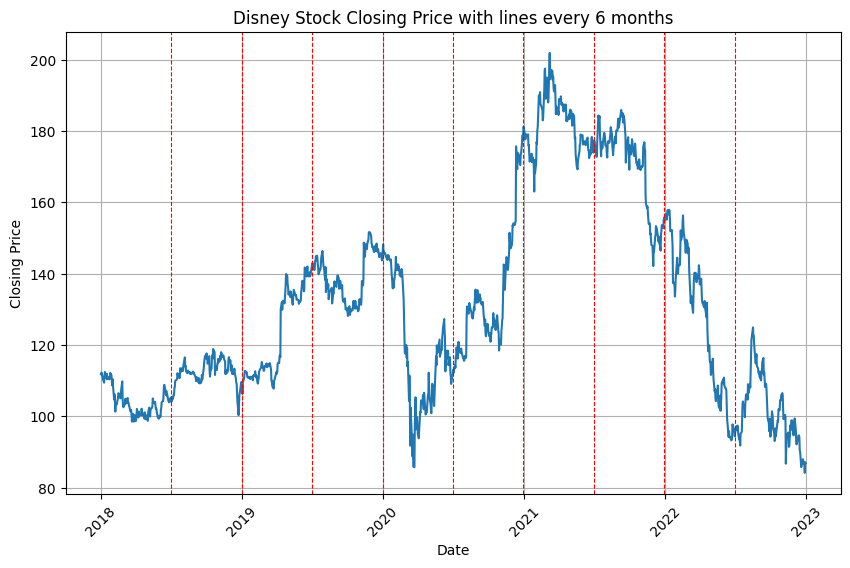

In [10]:
dates = df.index
close = df["Close"]

plt.figure(figsize=(10, 6))
plt.plot(dates, close)
plt.title('Disney Stock Closing Price with lines every 6 months')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)

season_est = 9

x_ticks = np.linspace(0, len(dates) - 1, num=season_est + 2, dtype=int)[1:-1]
x_positions = dates[x_ticks]
for x in x_positions:
    plt.axvline(x=x, color='r', linestyle='--', linewidth=0.8)

    
plt.show()

<b> Stationarity Testing

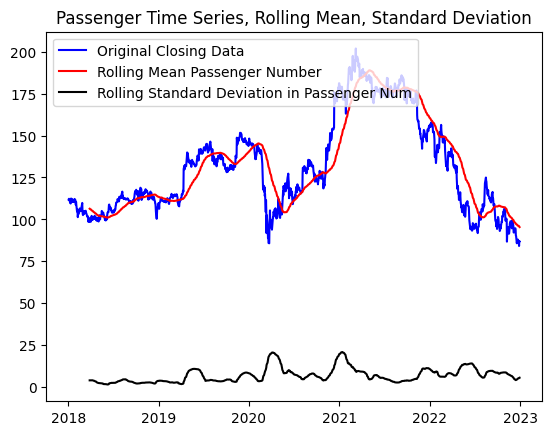

In [11]:
rolling = 60
rolling_mean = close.rolling(rolling).mean()
rolling_std = close.rolling(rolling).std()

plt.plot(close, color="blue",label="Original Closing Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Num")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [12]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(close,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],
                                    adft[1],
                                    adft[2],
                                    adft[3],
                                    adft[4]['1%'],
                                    adft[4]['5%'],
                                    adft[4]['10%']],
                                    "Metric":["Test Statistics",
                                    "p-value",
                                    "No. of lags used",
                                    "Number of observations used",
                                    "critical value (1%)",
                                    "critical value (5%)",
                                    "critical value (10%)"]})
print(output_df)

        Values                       Metric
0    -1.324635              Test Statistics
1     0.617828                      p-value
2    10.000000             No. of lags used
3  1248.000000  Number of observations used
4    -3.435601          critical value (1%)
5    -2.863859          critical value (5%)
6    -2.568004         critical value (10%)


<b> Auto Correlation

In [13]:
autocorrelation_lag1 = df['Close'].autocorr(lag=1)
print("One Day Lag: ", autocorrelation_lag1)

One Day Lag:  0.9958323221394508


In [14]:
autocorrelation_lag1 = df['Close'].autocorr(lag=20)
print("One Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.9197544297903115


In [15]:
autocorrelation_lag2 = df['Close'].autocorr(lag=40)
print("Three Month Lag: ", autocorrelation_lag2)
autocorrelation_lag3 = df['Close'].autocorr(lag=60)
print("Three Month Lag: ", autocorrelation_lag3)
autocorrelation_lag6 = df['Close'].autocorr(lag=120)
print("Six Month Lag: ", autocorrelation_lag6)
autocorrelation_lag9 = df['Close'].autocorr(lag=240)
print("One Year Lag: ", autocorrelation_lag9)

Three Month Lag:  0.8272552364216113
Three Month Lag:  0.7243515334291292
Six Month Lag:  0.43829221178228
One Year Lag:  -0.29427014042088734


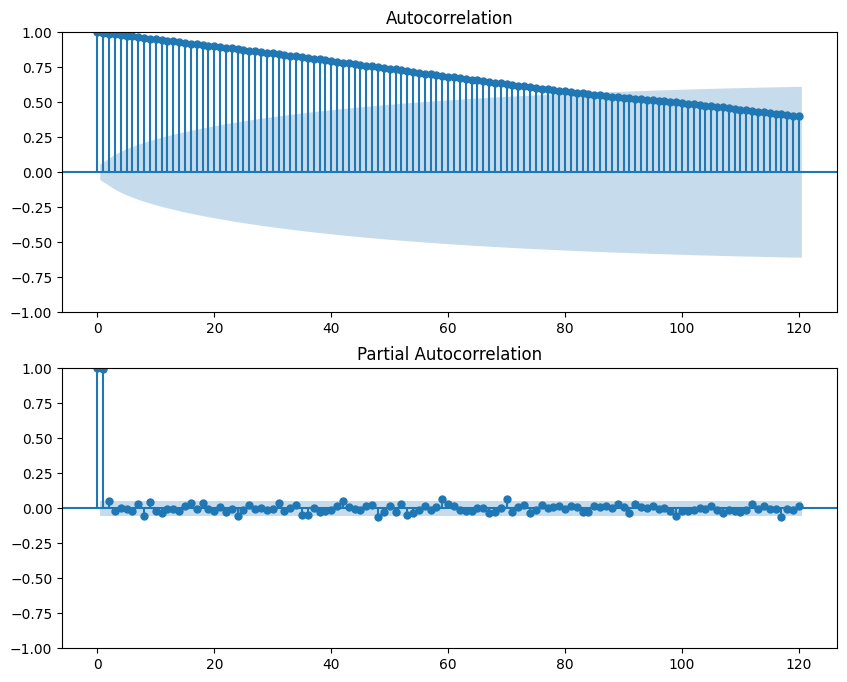

In [16]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = df["Close"]

# Plot the ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data, lags=120, ax=axes[0])
plot_pacf(data, lags=120, ax=axes[1])
plt.show()

### Data Wrangling

<b>Features Selection

In [17]:
#df = df.drop([cols], axis=1)
close

Date
2018-01-02    111.800003
2018-01-03    112.279999
2018-01-04    112.230003
2018-01-05    111.620003
2018-01-08    110.019997
                 ...    
2022-12-23     88.010002
2022-12-27     86.370003
2022-12-28     84.169998
2022-12-29     87.180000
2022-12-30     86.879997
Name: Close, Length: 1259, dtype: float64

<b>Data Transformation

In [18]:
df_log = np.log(close)
df_diff=df_log.diff().dropna()
df_diff

Date
2018-01-03    0.004284
2018-01-04   -0.000445
2018-01-05   -0.005450
2018-01-08   -0.014438
2018-01-09   -0.000727
                ...   
2022-12-23    0.015343
2022-12-27   -0.018810
2022-12-28   -0.025802
2022-12-29    0.035136
2022-12-30   -0.003447
Name: Close, Length: 1258, dtype: float64

In [19]:
df_diff.describe()

count    1258.000000
mean       -0.000200
std         0.020550
min        -0.141139
25%        -0.009727
50%        -0.000090
75%         0.009128
max         0.134639
Name: Close, dtype: float64

<b>Adding Constant

In [20]:
constant = 1
df_diff = df_diff + constant

In [21]:
df_diff.describe()

count    1258.000000
mean        0.999800
std         0.020550
min         0.858861
25%         0.990273
50%         0.999910
75%         1.009128
max         1.134639
Name: Close, dtype: float64

<b>Stationarity Testing

In [22]:
adft = adfuller(df_diff,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],
                                    adft[1],
                                    adft[2],
                                    adft[3],
                                    adft[4]['1%'],
                                    adft[4]['5%'],
                                    adft[4]['10%']],
                                    "Metric":["Test Statistics",
                                    "p-value",
                                    "No. of lags used",
                                    "Number of observations used",
                                    "critical value (1%)",
                                    "critical value (5%)",
                                    "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -1.152957e+01              Test Statistics
1  3.861234e-21                      p-value
2  8.000000e+00             No. of lags used
3  1.249000e+03  Number of observations used
4 -3.435596e+00          critical value (1%)
5 -2.863857e+00          critical value (5%)
6 -2.568004e+00         critical value (10%)


### Decomposition

<b>Time Series Decomposition Additive (Six Months Seasonality)

In [23]:
period=120
x = df_diff

In [24]:
ts_dicomposition = seasonal_decompose(x=x, model='additive', period=period)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

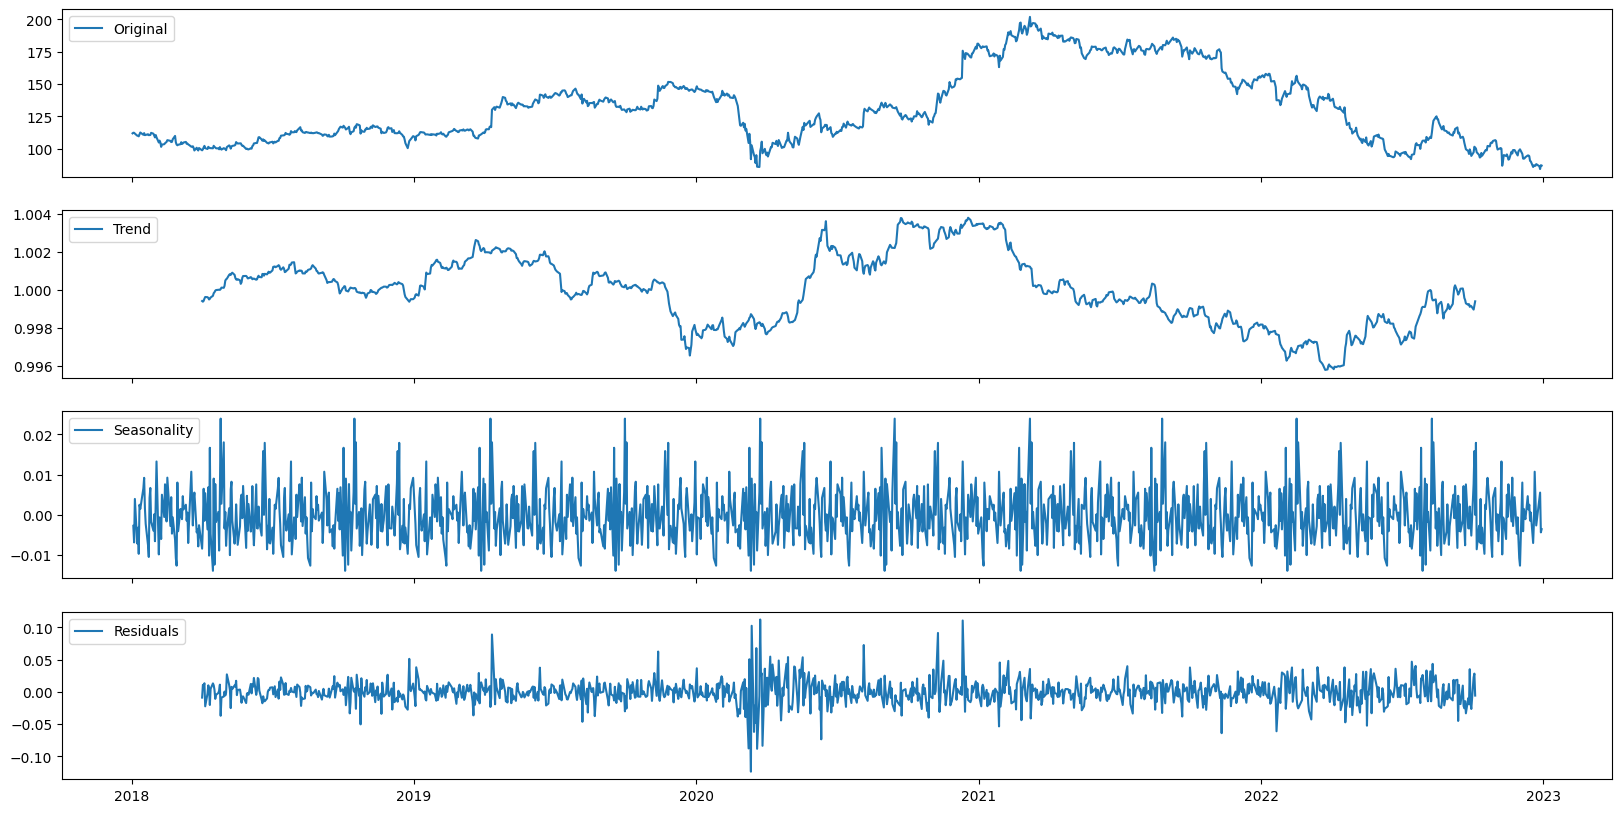

In [25]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(df["Close"], label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');


<b>Time Series Decomposition Multicative (Six Months Seasonality)

In [26]:
ts_decomposition = seasonal_decompose(close, model='multiplicative', period=period)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

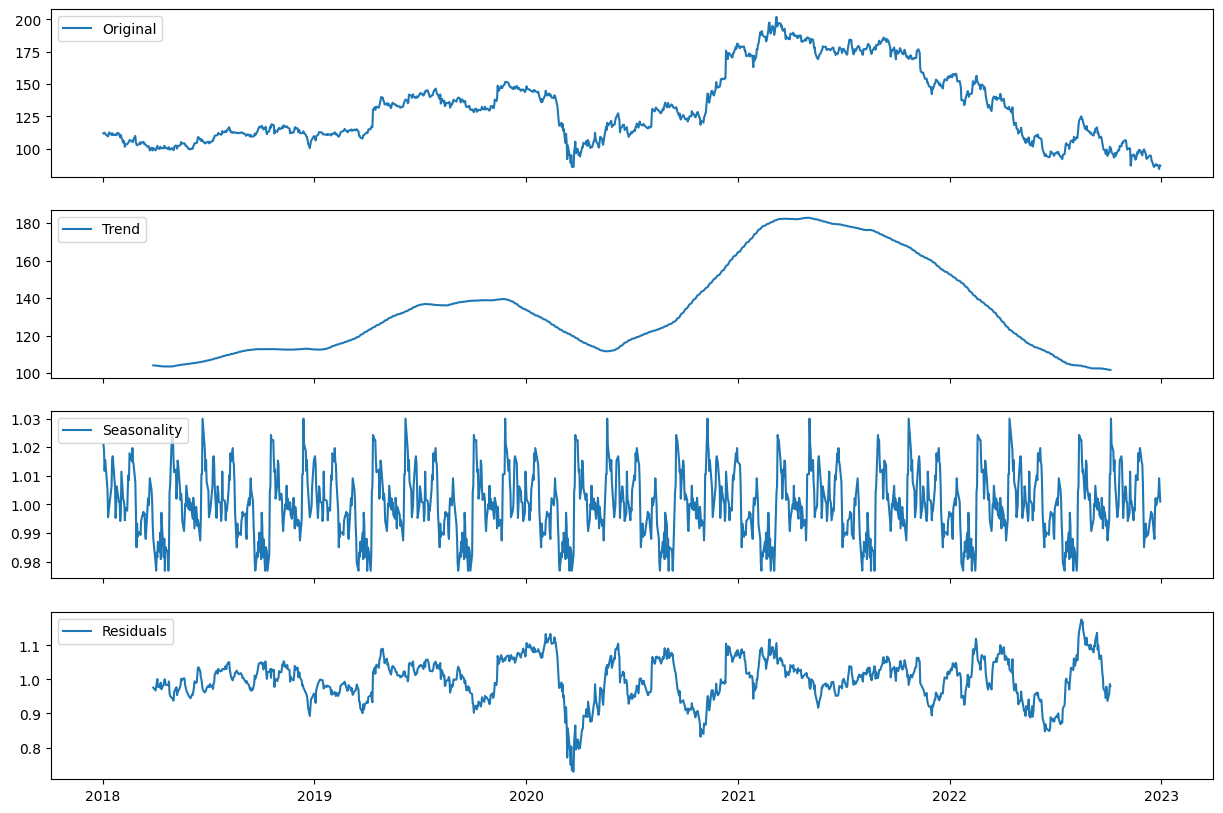

In [27]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df["Close"], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');


<b>Time Series Decomposition Additive (Monthly Seasonality)

In [28]:
period=20
x = df_diff

In [29]:
ts_dicomposition = seasonal_decompose(x=x, model='additive', period=period)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

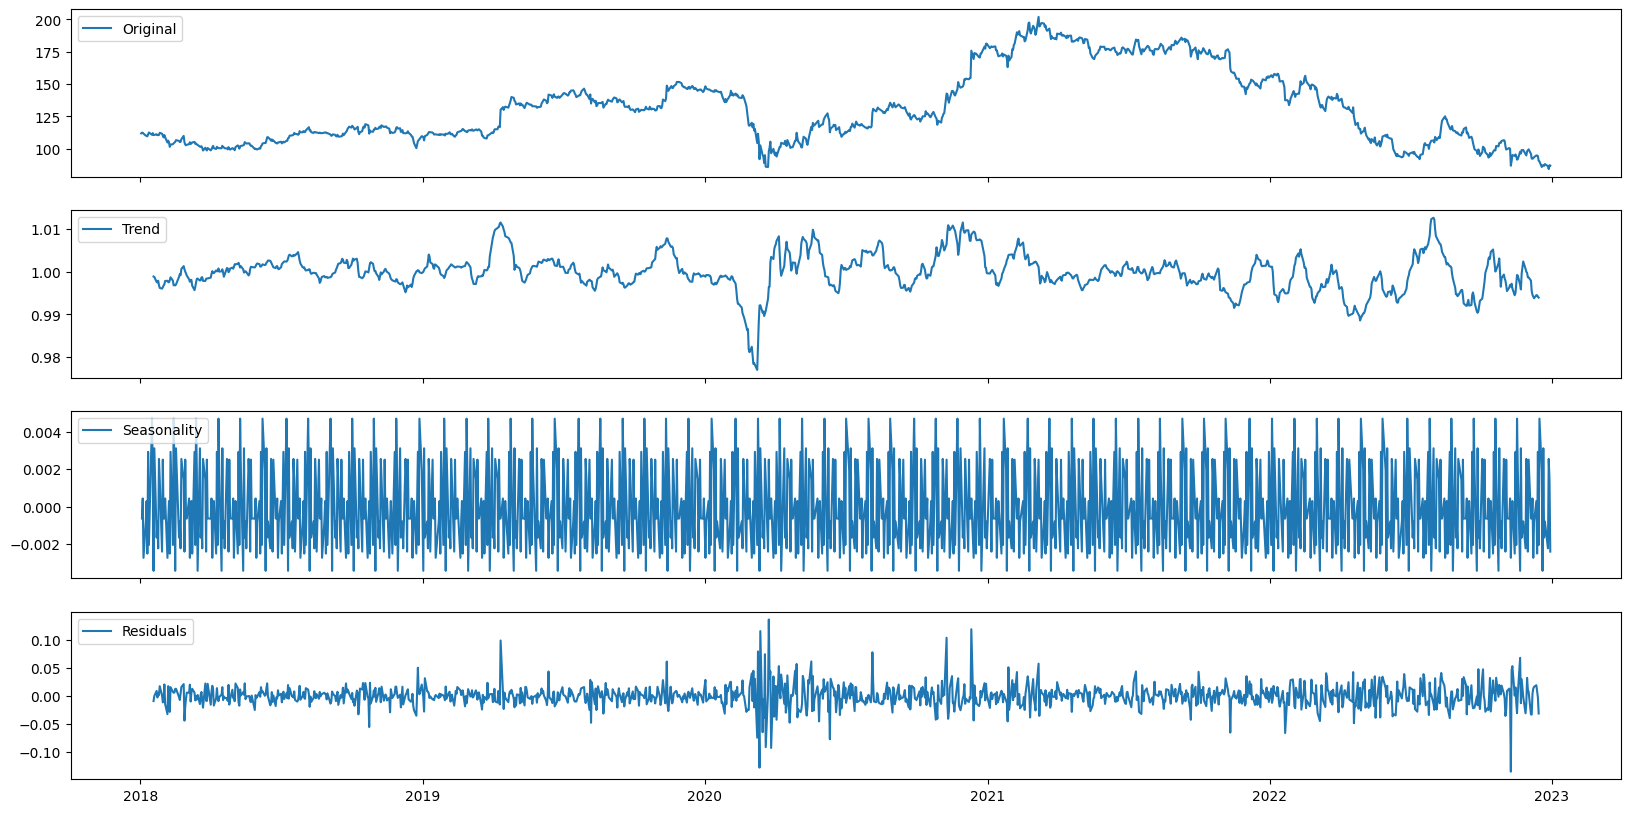

In [30]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(df["Close"], label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');


<b>Time Series Decomposition Multicative (Monthly Seasonality)

In [31]:
ts_decomposition = seasonal_decompose(close, model='multiplicative', period=period)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

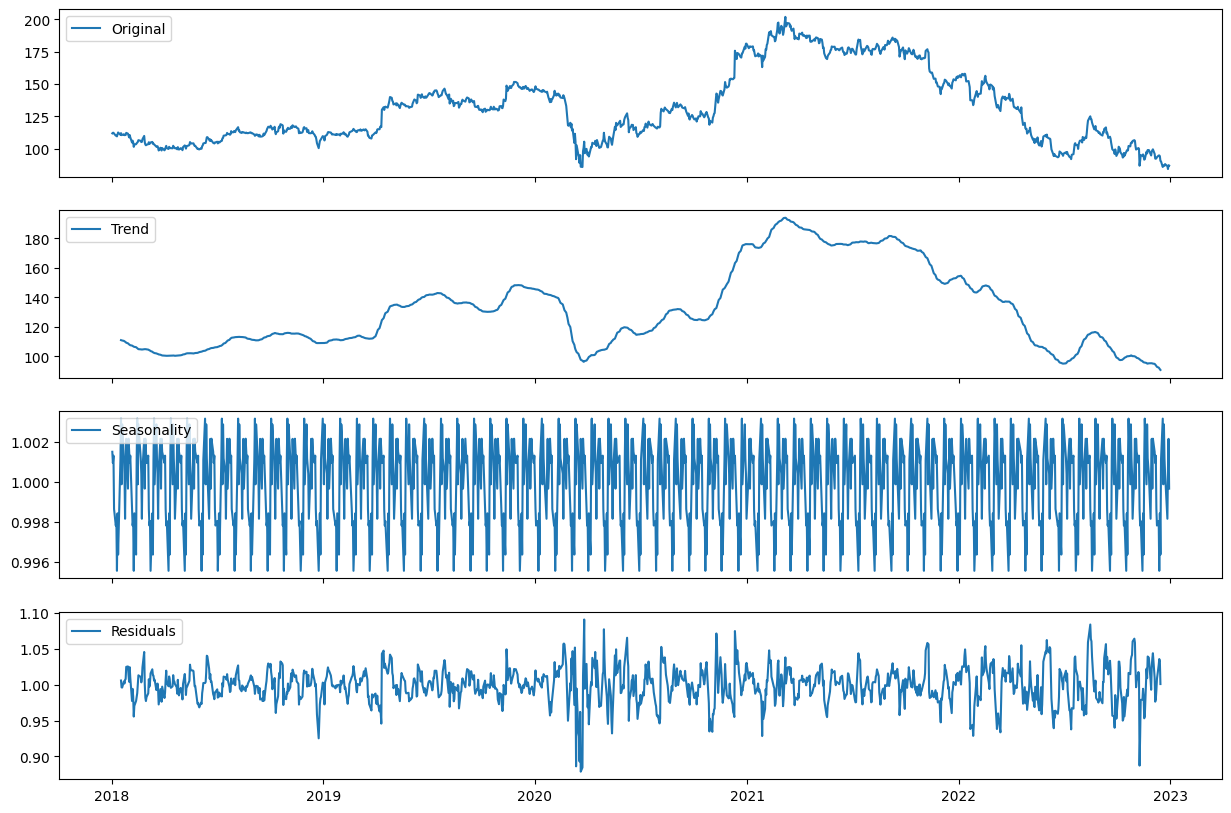

In [32]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df["Close"], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');


### Preprocessing

<b>Imports

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
res_df = residual_estimate.dropna()

In [35]:
df1 = df["Close"].to_frame()

In [36]:
df1.describe()

,Close
count,1259.000000
mean,131.199785
std,28.045108
min,84.169998
25%,109.564999
50%,124.980003
75%,147.284996
max,201.910004


<b>Scale Data

In [37]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df1[['Close']])
scaled_data

array([[0.23466964],
       [0.23874638],
       [0.23832176],
       ...,
       [0.        ],
       [0.02556482],
       [0.02301681]])

<b>Splitting Dataset

In [38]:
split_index = int(len(scaled_data) * 0.8)

In [39]:
train = scaled_data[:split_index]
x_test = scaled_data[split_index-20:]

In [40]:
x_training_data = []
y_training_data =[]

In [41]:
days = 20

In [42]:
for i in range(days, len(train)):
    x_training_data.append(train[i-days:i, 0])
    y_training_data.append(train[i, 0])

In [43]:
x_training_data = np.array(x_training_data)
y_training_data = np.array(y_training_data)

In [44]:
print(x_training_data.shape)
print(y_training_data.shape)

(987, 20)
(987,)


In [45]:
x_training_data = np.reshape(x_training_data, (x_training_data.shape[0],x_training_data.shape[1],1))

In [46]:
print(x_training_data.shape)
print(y_training_data.shape)

(987, 20, 1)
(987,)


### Modelling

<b> Imports

In [47]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

<b> Create Model

In [48]:
rnn = Sequential()

<b>Add First Layer

In [49]:
rnn.add(LSTM(units = 40, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
rnn.add(Dropout(0.2))

<b>Add Next Layers

In [50]:
rnn.add(LSTM(units = 20, return_sequences = True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units = 20, return_sequences = True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units = 20))
rnn.add(Dropout(0.2))

In [51]:
# loop if required
#for i in [True, True, False]:
#    rnn.add(LSTM(units = 25, return_sequences = i))
#    rnn.add(Dropout(0.2))

<b> Output Layer

In [52]:
rnn.add(Dense(units = 1))

<b>Compile Recurrent Nueral Network

In [53]:
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

<b>Fit the RNN

In [54]:
rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32, verbose=0)

<b>Reshaping x_test

In [55]:
x_test = np.reshape(x_test, (-1,1))
x_test.shape

(272, 1)

In [56]:
x_test_data = []
for i in range(20, len(x_test)):
    x_test_data.append(x_test[i-20:i, 0])
x_test_data = np.array(x_test_data)
x_test_data.shape

(252, 20)

In [57]:
x_test_data = np.reshape(x_test_data,(x_test_data.shape[0], x_test_data.shape[1],1))
x_test_data.shape

(252, 20, 1)

<b>Making predictions

In [58]:
predictions = rnn.predict(x_test_data)

8/8 [==============================] - 1s 4ms/step


In [59]:
predictions.shape

(252, 1)

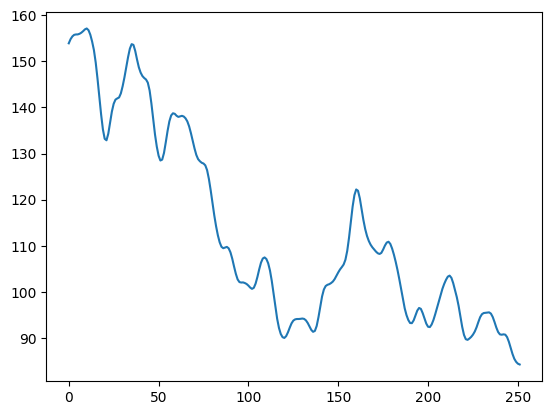

In [60]:
unscaled_predictions = scaler.inverse_transform(predictions)
plt.plot(unscaled_predictions)

<b>Original X Test

In [61]:
unscaled_predictions.shape

(252, 1)

In [62]:
x_test.shape

(272, 1)

In [63]:
x_test = scaled_data[split_index:]

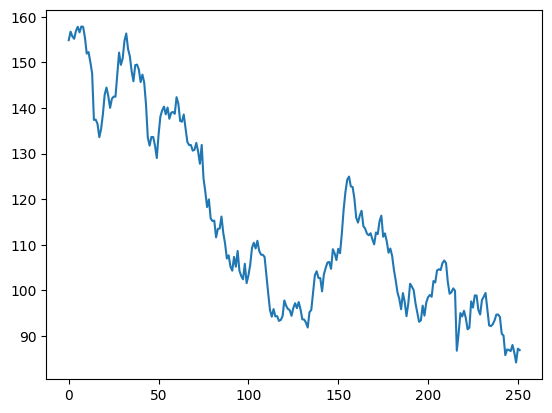

In [64]:
x_test = np.reshape(x_test, (-1,1))
x_test = scaler.inverse_transform(x_test)
plt.plot(x_test)

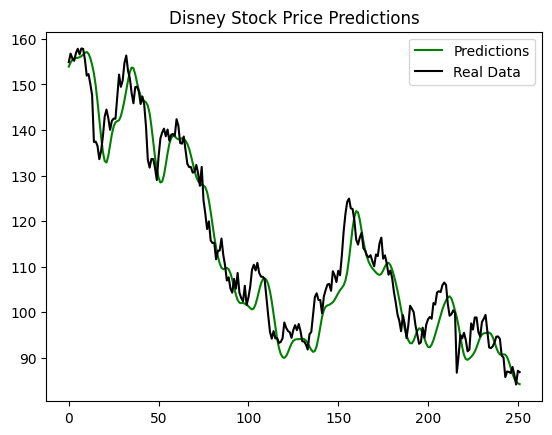

In [65]:
plt.plot(unscaled_predictions, color = 'green', label = "Predictions")
plt.plot(x_test, color = 'black', label = "Real Data")
plt.title('Disney Stock Price Predictions')
plt.legend()

In [66]:
mse = mean_squared_error(x_test, unscaled_predictions)
mse

26.39689496626901

In [67]:
r2 = r2_score(x_test, unscaled_predictions)
r2

0.9369366320088957

<b>Adding to Results

In [68]:
results_df = pd.DataFrame()

In [69]:
results_df.loc["Untuned RNN (Training)", ["MSE", "r2"]] = [mse, r2]

<b>Predicting stock prices for a month

In [70]:
x_test_month = scaled_data[split_index-20:split_index+20]
x_test_month.shape

(40, 1)

In [71]:
x_test_month_data=[]

In [72]:
for i in range(20, len(x_test_month)):
    x_test_month_data.append(x_test_month[i-20:i, 0])
x_test_month_data = np.array(x_test_month_data)
x_test_month_data = np.reshape(x_test_month_data, (x_test_month_data.shape[0], 20))

x_test_month_data.shape

(20, 20)

In [73]:
x_test_month_data = np.reshape(x_test_month_data,(x_test_month_data.shape[0], x_test_month_data.shape[1],1))
x_test_month_data.shape

(20, 20, 1)

In [74]:
predictions_month = rnn.predict(x_test_month_data)

1/1 [==============================] - 0s 16ms/step


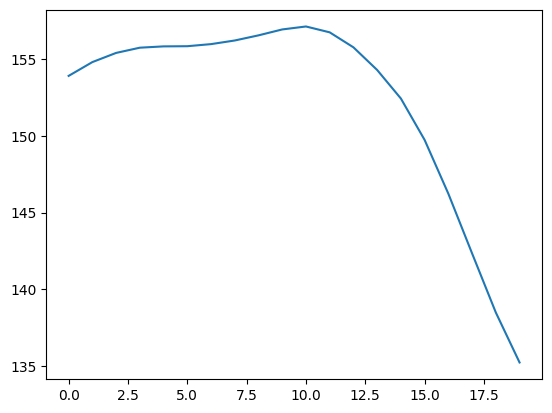

In [75]:
unscaled_predictions_m = scaler.inverse_transform(predictions_month)
plt.plot(unscaled_predictions_m)

<b>Matching Real data

In [76]:
x_test_month = scaled_data[split_index:split_index+20]

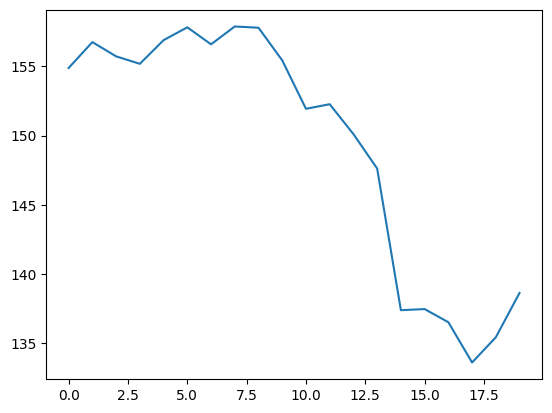

In [77]:
x_test_month = np.reshape(x_test_month, (-1,1))
x_test_month = scaler.inverse_transform(x_test_month)
plt.plot(x_test_month)

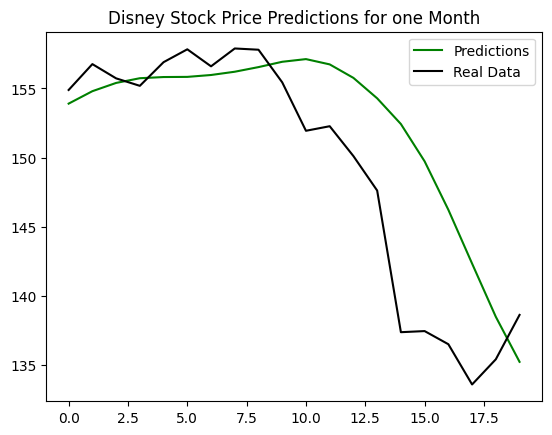

In [78]:
plt.plot(unscaled_predictions_m, color = 'green', label = "Predictions")
plt.plot(x_test_month, color = 'black', label = "Real Data")
plt.title('Disney Stock Price Predictions for one Month')
plt.legend()

In [79]:
mse = mean_squared_error(x_test_month, unscaled_predictions_m)
mse

35.471389050153086

In [80]:
r2 = r2_score(x_test_month, unscaled_predictions_m)
r2

0.5418918620271609

In [81]:
results_df.loc["Untuned RNN (month prediction)", ["MSE", "r2"]] = [mse, r2]

### Hyperparameter Tuning

<b>Imports

In [82]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel, RandomSearch
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV

<b>n_jobs set here

In [83]:
# If the code is restarted and ran n_jobs should be -1
# I had best results with n_jobs=5
#n_jobs=-1
n_jobs=5

<b>Create Model

In [84]:
def create_model(initial_unit=40, units=20, dropout_rate=0.2, num_layers=2, optimizer = 'adam', learning_rate=0.001, momentum=0.9, epochs=100, batch_size=20):
    model = Sequential()  
    model.add(LSTM(units = initial_unit, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers):
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units = units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error')
    return model
model = KerasRegressor(build_fn=create_model)

<b>Batch Size

In [85]:
param_grid = {
    'epochs': [10,50,100,150],
    'batch_size': [10, 20, 40, 60, 80, 100]
    #'optimizer': ['adam', 'rmsprop', 'Adagrad', 'Nadam'],
    #'initial_unit' : [20,30,40],
    #'units': [20, 40]
    #'dropout_rate': [0.2, 0.3, 0.4]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, verbose=0)
grid_result = grid.fit(x_training_data, y_training_data)

Epoch 1/100
99/99 [==============================] - 5s 12ms/step - loss: 0.0331
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0090
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0096
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0081
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0074
Epoch 6/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0072
Epoch 7/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0067
Epoch 8/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0066
Epoch 9/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 10/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 11/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 12/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 13/100
99/99 [=====

In [86]:
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)
print("Best estimator:", grid_result.best_estimator_)

# Accessing detailed results
cv_results = grid_result.cv_results_
print("Mean test scores:", cv_results["mean_test_score"])
print("Mean fit times:", cv_results["mean_fit_time"])

# Evaluate the best estimator on training data
train_score = grid_result.score(x_training_data, y_training_data)
print("Train score:", train_score)

# Evaluate the best estimator on training data
train_loss = grid_result.best_estimator_.score(x_training_data, y_training_data)
print("Train loss:", train_loss)

Best parameters: {'batch_size': 10, 'epochs': 100}
Best score: -0.0007736369443591684
Best estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D86B8FAD30>
Mean test scores: [-0.00413998 -0.00197733 -0.00077364 -0.00118571 -0.00636606 -0.00237402
 -0.00123744 -0.00149862 -0.00471947 -0.00413494 -0.00228277 -0.00165816
 -0.00708248 -0.00446133 -0.00255076 -0.00309941 -0.00395507 -0.00888933
 -0.00282193 -0.00209096 -0.00468933 -0.00509553 -0.00334004 -0.00210871]
Mean fit times: [ 21.34918308  72.72353506 138.06512181 250.84883412  21.38296334
  71.47436627 190.14031005 202.28089229  15.62160031  38.4758052
 104.64237976 118.9713366   14.3156662   28.1393342   45.12099918
  69.06266665  12.66433398  27.35999688  44.77399762  57.77561577
  11.35385346  23.15666437  42.00199922  55.29441309]
99/99 [==============================] - 1s 3ms/step - loss: 6.5817e-04
Train score: -0.0006581709021702409
99/99 [==============================] - 0s 3ms/step - loss: 6.5817e-04


In [87]:
cv_results = grid_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

for mean_score, param in zip(mean_test_scores, params):
    print("Parameters:", param)
    print("Mean Test Score:", mean_score, "\n")

Parameters: {'batch_size': 10, 'epochs': 10}
Mean Test Score: -0.004139976886411508 

Parameters: {'batch_size': 10, 'epochs': 50}
Mean Test Score: -0.001977334846742451 

Parameters: {'batch_size': 10, 'epochs': 100}
Mean Test Score: -0.0007736369443591684 

Parameters: {'batch_size': 10, 'epochs': 150}
Mean Test Score: -0.0011857101490022615 

Parameters: {'batch_size': 20, 'epochs': 10}
Mean Test Score: -0.006366061240745087 

Parameters: {'batch_size': 20, 'epochs': 50}
Mean Test Score: -0.0023740216080720225 

Parameters: {'batch_size': 20, 'epochs': 100}
Mean Test Score: -0.0012374381185509264 

Parameters: {'batch_size': 20, 'epochs': 150}
Mean Test Score: -0.0014986211705642443 

Parameters: {'batch_size': 40, 'epochs': 10}
Mean Test Score: -0.0047194732663532095 

Parameters: {'batch_size': 40, 'epochs': 50}
Mean Test Score: -0.0041349408371994896 

Parameters: {'batch_size': 40, 'epochs': 100}
Mean Test Score: -0.002282769807303945 

Parameters: {'batch_size': 40, 'epochs': 1

<b>Training Optimisation Algorithm

In [88]:
model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=10)

In [89]:
param_grid = {
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    #'initial_unit' : [20,30,40],
    #'units': [20, 40]
    #'dropout_rate': [0.2, 0.3, 0.4]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, verbose=0)
grid_result = grid.fit(x_training_data, y_training_data)

Epoch 1/150
99/99 [==============================] - 5s 12ms/step - loss: 0.0271
Epoch 2/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0098
Epoch 3/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0085
Epoch 4/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0082
Epoch 5/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0070
Epoch 6/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0070
Epoch 7/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0067
Epoch 8/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0065
Epoch 9/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0060
Epoch 10/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0054
Epoch 11/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0057
Epoch 12/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0056
Epoch 13/150
99/99 [=====

99/99 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 102/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 103/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 104/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 105/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 106/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 107/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 108/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 109/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 110/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 111/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 112/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 113/150
99/9

In [90]:
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)
print("Best estimator:", grid_result.best_estimator_)

# Accessing detailed results
cv_results = grid_result.cv_results_
print("Mean test scores:", cv_results["mean_test_score"])
print("Mean fit times:", cv_results["mean_fit_time"])

# Evaluate the best estimator on training data
train_score = grid_result.score(x_training_data, y_training_data)
print("Train score:", train_score)

Best parameters: {'optimizer': 'Adam'}
Best score: -0.001305335162517925
Best estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D86BB41B80>
Mean test scores: [-0.00724279 -0.00157064 -0.00996226 -0.06670899 -0.00130534 -0.0014317
 -0.00251511]
Mean fit times: [330.14957237 344.8643655  330.35417072 375.25025646 392.73433328
 344.21233233 304.95940248]
99/99 [==============================] - 1s 3ms/step - loss: 6.7803e-04
Train score: -0.0006780257099308074


In [91]:
cv_results = grid_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

for mean_score, param in zip(mean_test_scores, params):
    accuracy = mean_score * 100
    print("Parameters:", param)
    print("Mean Test Score:", mean_score)
    print("Mean Test Score (Accuracy): {:.2f}%".format(accuracy))

Parameters: {'optimizer': 'SGD'}
Mean Test Score: -0.0072427886771038175
Mean Test Score (Accuracy): -0.72%
Parameters: {'optimizer': 'RMSprop'}
Mean Test Score: -0.0015706394721443455
Mean Test Score (Accuracy): -0.16%
Parameters: {'optimizer': 'Adagrad'}
Mean Test Score: -0.009962263788717488
Mean Test Score (Accuracy): -1.00%
Parameters: {'optimizer': 'Adadelta'}
Mean Test Score: -0.06670899068315823
Mean Test Score (Accuracy): -6.67%
Parameters: {'optimizer': 'Adam'}
Mean Test Score: -0.001305335162517925
Mean Test Score (Accuracy): -0.13%
Parameters: {'optimizer': 'Adamax'}
Mean Test Score: -0.0014316957482757668
Mean Test Score (Accuracy): -0.14%
Parameters: {'optimizer': 'Nadam'}
Mean Test Score: -0.0025151108857244253
Mean Test Score (Accuracy): -0.25%


<b>Tuning Learning Rate and Momentum

In [92]:
from tensorflow.keras.optimizers import Adam

In [93]:
def create_model(initial_unit=20, units=20, dropout_rate=0.2, num_layers=2, optimizer = 'adam', learning_rate=0.001, 
                 momentum=0.9, activation='tanh'):
    model = Sequential()  
    model.add(LSTM(units = initial_unit, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers):
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units = units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1))
    opt = Adam(lr=learning_rate, beta_1=momentum)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error')
    return model
model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=10, optimizer="adam")

In [94]:
param_grid = {
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "momentum": [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
    #'initial_unit' : [20,30,40],
    #'units': [20, 40]
    #'dropout_rate': [0.2, 0.3, 0.4]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, verbose=0)
grid_result = grid.fit(x_training_data, y_training_data)

Epoch 1/150
99/99 [==============================] - 5s 11ms/step - loss: 0.0276
Epoch 2/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0104
Epoch 3/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0084
Epoch 4/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0092
Epoch 5/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0077
Epoch 6/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0078
Epoch 7/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0071
Epoch 8/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0067
Epoch 9/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0067
Epoch 10/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 11/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 12/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 13/150
99/99 [=====

99/99 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 102/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0016
Epoch 103/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 104/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 105/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0019
Epoch 106/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0016
Epoch 107/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0016
Epoch 108/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 109/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 110/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 111/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 112/150
99/99 [==============================] - 1s 11ms/step - loss: 0.0016
Epoch 113/150
99/9

In [95]:
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)
print("Best estimator:", grid_result.best_estimator_)

# Accessing detailed results
cv_results = grid_result.cv_results_
print("Mean test scores:", cv_results["mean_test_score"])
print("Mean fit times:", cv_results["mean_fit_time"])

# Evaluate the best estimator on training data
train_score = grid_result.score(x_training_data, y_training_data)
print("Train score:", train_score)

Best parameters: {'learning_rate': 0.2, 'momentum': 0.2}
Best score: -0.0007597590156365186
Best estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D855B1A490>
Mean test scores: [-0.00298517 -0.00135225 -0.00250898 -0.0039189  -0.00142083 -0.00183502
 -0.00210733 -0.00241722 -0.00297473 -0.00252045 -0.00281781 -0.00127736
 -0.00230248 -0.00530606 -0.00089966 -0.00174651 -0.00233333 -0.00340321
 -0.00172218 -0.00075976 -0.00296903 -0.00380376 -0.0033794  -0.00272371
 -0.0020006  -0.00264915 -0.00373466 -0.00407193 -0.00511841 -0.00295767]
Mean fit times: [279.53333131 190.50899744 247.99999849 258.31533543 212.06766518
 306.74733384 193.09600012 241.88133136 264.13600103 281.36401566
 250.97894661 359.97261628 335.44622254 271.74263978 285.81244222
 389.4481496  316.96692411 390.16473595 396.8030529  333.09383845
 452.70612311 370.47146535 393.2715408  386.80553285 408.2727081
 344.36194897 586.07550955 421.59348369 381.16628321 230.5923175 ]
99/99 [===============

<b>Tuning Neuron Activation Function

In [96]:
def create_model(initial_unit=20, units=20, dropout_rate=0.2, num_layers=2, optimizer='adam', learning_rate=0.001,
                 momentum=0.9, activation='tanh'):
    model = Sequential()  
    model.add(LSTM(units=initial_unit, return_sequences=True, input_shape=(x_training_data.shape[1], 1),
                   activation=activation))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers):
        model.add(LSTM(units=units, return_sequences=True, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation=activation))
    opt = Adam(learning_rate=learning_rate, beta_1=momentum)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [97]:
model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=10, optimizer="adam",
                      learning_rate=0.2, momentum=0.4)

In [98]:
param_grid = {
    "activation": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    #'initial_unit' : [20,30,40],
    #'units': [20, 40]
    #'dropout_rate': [0.2, 0.3, 0.4]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, verbose=0)
grid_result = grid.fit(x_training_data, y_training_data)

Epoch 1/150
99/99 [==============================] - 3s 9ms/step - loss: 0.0317
Epoch 2/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0108
Epoch 3/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0104
Epoch 4/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0087
Epoch 5/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 6/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 7/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 8/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 9/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0065
Epoch 10/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0064
Epoch 11/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0065
Epoch 12/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0055
Epoch 13/150
99/99 [=================

99/99 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 103/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 104/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0016
Epoch 105/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 106/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 107/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 108/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 109/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0016
Epoch 110/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 111/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 112/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 113/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 114/150
99/99 [=========

In [99]:
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)
print("Best estimator:", grid_result.best_estimator_)

# Accessing detailed results
cv_results = grid_result.cv_results_
print("Mean test scores:", cv_results["mean_test_score"])
print("Mean fit times:", cv_results["mean_fit_time"])

# Evaluate the best estimator on training data
train_score = grid_result.score(x_training_data, y_training_data)
print("Train score:", train_score)

Best parameters: {'activation': 'linear'}
Best score: -0.0010108938101135816
Best estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D86B8E8400>
Mean test scores: [-0.37215048 -0.02581844 -0.00444436 -0.0142439  -0.00330255 -0.01780918
 -0.02115918 -0.00101089]
Mean fit times: [267.73222931 155.76503444 207.76272416 217.52070761 182.16651185
 261.53966673 272.92133363 167.16002909]
99/99 [==============================] - 1s 2ms/step - loss: 7.1376e-04
Train score: -0.0007137586362659931


In [100]:
cv_results = grid_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

for mean_score, param in zip(mean_test_scores, params):
    accuracy = mean_score * 100
    print("Parameters:", param)
    print("Mean Test Score:", mean_score)
    print("Mean Test Score (Accuracy): {:.2f}%".format(accuracy))

Parameters: {'activation': 'softmax'}
Mean Test Score: -0.3721504807472229
Mean Test Score (Accuracy): -37.22%
Parameters: {'activation': 'softplus'}
Mean Test Score: -0.02581844129599631
Mean Test Score (Accuracy): -2.58%
Parameters: {'activation': 'softsign'}
Mean Test Score: -0.004444362760599081
Mean Test Score (Accuracy): -0.44%
Parameters: {'activation': 'relu'}
Mean Test Score: -0.014243902793775002
Mean Test Score (Accuracy): -1.42%
Parameters: {'activation': 'tanh'}
Mean Test Score: -0.003302551699259008
Mean Test Score (Accuracy): -0.33%
Parameters: {'activation': 'sigmoid'}
Mean Test Score: -0.017809183550222468
Mean Test Score (Accuracy): -1.78%
Parameters: {'activation': 'hard_sigmoid'}
Mean Test Score: -0.021159180459411193
Mean Test Score (Accuracy): -2.12%
Parameters: {'activation': 'linear'}
Mean Test Score: -0.0010108938101135816
Mean Test Score (Accuracy): -0.10%


<b> Tuning Number of Nueron Layers

In [101]:
model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=10, optimizer="adam",
                      learning_rate=0.2, momentum=0.4)

In [102]:
param_grid = {
    "num_layers": [1, 2, 3, 4, 5]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3)
grid_result = grid.fit(x_training_data, y_training_data)

Epoch 1/150
99/99 [==============================] - 3s 8ms/step - loss: 0.0234
Epoch 2/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0072
Epoch 3/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0054
Epoch 4/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 5/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0056
Epoch 6/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 7/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0045
Epoch 8/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 9/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 10/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 11/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 12/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 13/150
99/99 [=================

99/99 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 103/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 104/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 105/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 106/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0014
Epoch 107/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 108/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 109/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 110/150
99/99 [==============================] - 1s 9ms/step - loss: 0.0012
Epoch 111/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 112/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 113/150
99/99 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 114/150
99/99 [=========

In [103]:
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)
print("Best estimator:", grid_result.best_estimator_)

# Accessing detailed results
cv_results = grid_result.cv_results_
print("Mean test scores:", cv_results["mean_test_score"])
print("Mean fit times:", cv_results["mean_fit_time"])

# Evaluate the best estimator on training data
train_score = grid_result.score(x_training_data, y_training_data)
print("Train score:", train_score)

Best parameters: {'num_layers': 1}
Best score: -0.0018529666025036324
Best estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D807C7DA00>
Mean test scores: [-0.00185297 -0.00393804 -0.01125207 -0.01662946 -0.01696442]
Mean fit times: [174.64799746 214.16333048 315.22650234 350.0838515  384.18165882]
99/99 [==============================] - 1s 2ms/step - loss: 7.5856e-04
Train score: -0.0007585551938973367


In [104]:
cv_results = grid_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

for mean_score, param in zip(mean_test_scores, params):
    accuracy = mean_score * 100
    print("Parameters:", param)
    print("Mean Test Score:", mean_score)
    print("Mean Test Score (Accuracy): {:.2f}%".format(accuracy))

Parameters: {'num_layers': 1}
Mean Test Score: -0.0018529666025036324
Mean Test Score (Accuracy): -0.19%
Parameters: {'num_layers': 2}
Mean Test Score: -0.003938036194692056
Mean Test Score (Accuracy): -0.39%
Parameters: {'num_layers': 3}
Mean Test Score: -0.01125206978758797
Mean Test Score (Accuracy): -1.13%
Parameters: {'num_layers': 4}
Mean Test Score: -0.016629458017026384
Mean Test Score (Accuracy): -1.66%
Parameters: {'num_layers': 5}
Mean Test Score: -0.016964421840384603
Mean Test Score (Accuracy): -1.70%


In [105]:
model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=10, optimizer="adam",
                      learning_rate=0.2, momentum=0.4, activation="tanh", num_layers=1)

<b> Tuning Number of Nuerons Units

In [106]:
model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=10, optimizer="adam",
                      learning_rate=0.2, momentum=0.4, activation="tanh", num_layers=1)

In [107]:
param_grid = {
    "initial_unit": [20,40],
    "units": [20,40]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3)
grid_result = grid.fit(x_training_data, y_training_data)

Epoch 1/150
99/99 [==============================] - 4s 12ms/step - loss: 0.0183
Epoch 2/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0049
Epoch 3/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 4/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0048
Epoch 5/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 6/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 7/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0035
Epoch 8/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0031
Epoch 9/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 10/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 11/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 12/150
99/99 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 13/150
99/99 [=====

99/99 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 101/150
99/99 [==============================] - 1s 13ms/step - loss: 9.9354e-04
Epoch 102/150
99/99 [==============================] - 1s 13ms/step - loss: 9.2112e-04
Epoch 103/150
99/99 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 104/150
99/99 [==============================] - 1s 13ms/step - loss: 9.1517e-04
Epoch 105/150
99/99 [==============================] - 1s 12ms/step - loss: 9.6785e-04
Epoch 106/150
99/99 [==============================] - 1s 12ms/step - loss: 9.9054e-04
Epoch 107/150
99/99 [==============================] - 1s 12ms/step - loss: 9.7850e-04
Epoch 108/150
99/99 [==============================] - 1s 12ms/step - loss: 9.8612e-04
Epoch 109/150
99/99 [==============================] - 2s 17ms/step - loss: 9.1311e-04
Epoch 110/150
99/99 [==============================] - 2s 15ms/step - loss: 9.1027e-04
Epoch 111/150
99/99 [==============================] - 1s 15ms/st

In [108]:
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)
print("Best estimator:", grid_result.best_estimator_)

# Accessing detailed results
cv_results = grid_result.cv_results_
print("Mean test scores:", cv_results["mean_test_score"])
print("Mean fit times:", cv_results["mean_fit_time"])

# Evaluate the best estimator on training data
train_score = grid_result.score(x_training_data, y_training_data)
print("Train score:", train_score)

Best parameters: {'initial_unit': 40, 'units': 40}
Best score: -0.001501963590271771
Best estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D80BD7B460>
Mean test scores: [-0.00234689 -0.00273316 -0.00226102 -0.00150196]
Mean fit times: [174.0569888  137.22301133 136.86969964 155.94956382]
99/99 [==============================] - 1s 4ms/step - loss: 5.4227e-04
Train score: -0.0005422711255960166


In [109]:
cv_results = grid_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

for mean_score, param in zip(mean_test_scores, params):
    accuracy = mean_score * 100
    print("Parameters:", param)
    print("Mean Test Score:", mean_score)
    print("Mean Test Score (Accuracy): {:.2f}%".format(accuracy))

Parameters: {'initial_unit': 20, 'units': 20}
Mean Test Score: -0.0023468946067926786
Mean Test Score (Accuracy): -0.23%
Parameters: {'initial_unit': 20, 'units': 40}
Mean Test Score: -0.002733163487088556
Mean Test Score (Accuracy): -0.27%
Parameters: {'initial_unit': 40, 'units': 20}
Mean Test Score: -0.0022610157223728797
Mean Test Score (Accuracy): -0.23%
Parameters: {'initial_unit': 40, 'units': 40}
Mean Test Score: -0.001501963590271771
Mean Test Score (Accuracy): -0.15%


### Model Evaluation

<b>Selecting Optimal Tunings

In [112]:
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, optimizer="adam",
                      learning_rate=0.2, momentum=0.2, activation="linear", num_layers=1, initial_unit=40, units=40)

<b>Making Predictions

In [113]:
model.fit(x_training_data, y_training_data)

Epoch 1/100
99/99 [==============================] - 3s 13ms/step - loss: 0.0178
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0067
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0058
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0064
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0048
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047
Epoch 8/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047
Epoch 9/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0040
Epoch 10/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0035
Epoch 11/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0035
Epoch 12/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 13/100
99/99 [=====

In [114]:
x_test_data.shape

(252, 20, 1)

In [115]:
predictions = model.predict(x_test_data)

26/26 [==============================] - 0s 3ms/step


In [116]:
predictions.shape

(252,)

In [117]:
predictions_reshaped = predictions.reshape(-1, 1)

In [118]:
predictions_reshaped.shape

(252, 1)

In [119]:
unscaled_predictions_tuned = scaler.inverse_transform(predictions_reshaped)

In [120]:
unscaled_predictions_tuned.shape

(252, 1)

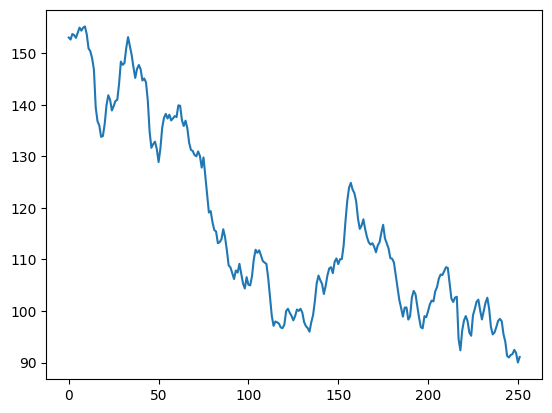

In [121]:
plt.plot(unscaled_predictions_tuned)

<b>Original X Test

In [122]:
x_test = scaled_data[split_index:]

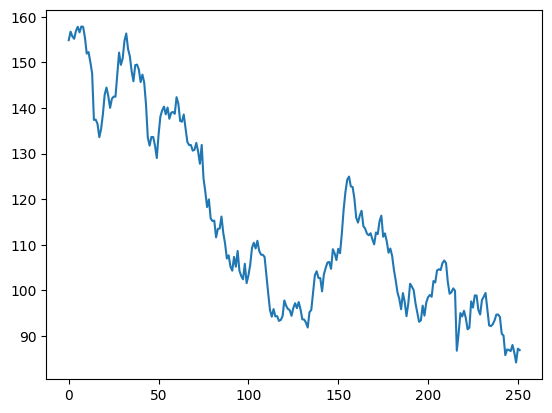

In [123]:
x_test = np.reshape(x_test, (-1,1))
x_test = scaler.inverse_transform(x_test)
plt.plot(x_test)

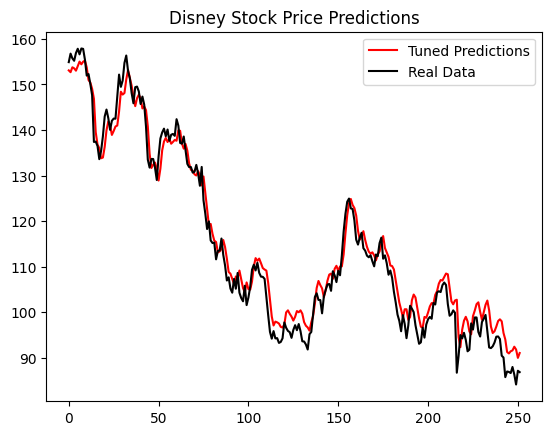

In [124]:
plt.plot(unscaled_predictions_tuned, color = 'red', label = "Tuned Predictions")
plt.plot(x_test, color = 'black', label = "Real Data")
plt.title('Disney Stock Price Predictions')
plt.legend()

In [125]:
mse = mean_squared_error(x_test, unscaled_predictions_tuned)
mse

13.196499882688396

In [126]:
r2 = r2_score(x_test, unscaled_predictions_tuned)
r2

0.9684729689094121

In [127]:
results_df.loc["Tuned RNN (Training)", ["MSE", "r2"]] = [mse, r2]

<b>Predicting Month

In [128]:
predictions_month_tuned = model.predict(x_test_month_data)

2/2 [==============================] - 0s 5ms/step


In [129]:
predictions_month_tuned = predictions_month_tuned.reshape(20, 1)

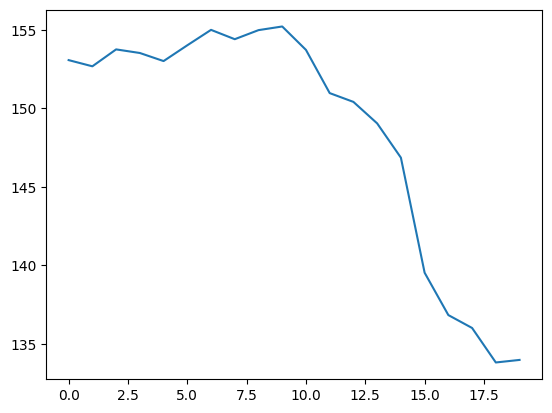

In [130]:
#predictions_month_tuned = predictions_month_tuned.reshape(1, -1)
unscaled_predictions_m_t = scaler.inverse_transform(predictions_month_tuned)
plt.plot(unscaled_predictions_m_t)

In [131]:
mse = mean_squared_error(x_test_month, unscaled_predictions_m_t)
mse

10.49673233490903

In [132]:
r2 = r2_score(x_test_month, unscaled_predictions_m_t)
r2

0.8644361375883668

In [133]:
results_df.loc["Tuned RNN (month prediction)", ["MSE", "r2"]] = [mse, r2]

<b>Plots

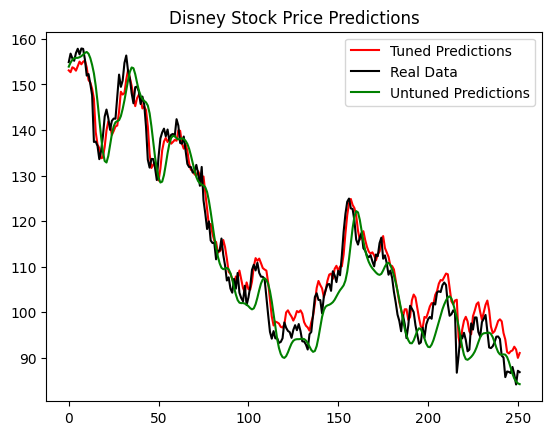

In [134]:
plt.plot(unscaled_predictions_tuned, color = 'red', label = "Tuned Predictions")
plt.plot(x_test, color = 'black', label = "Real Data")
plt.plot(unscaled_predictions, color = 'green', label = "Untuned Predictions")
plt.title('Disney Stock Price Predictions')
plt.legend()

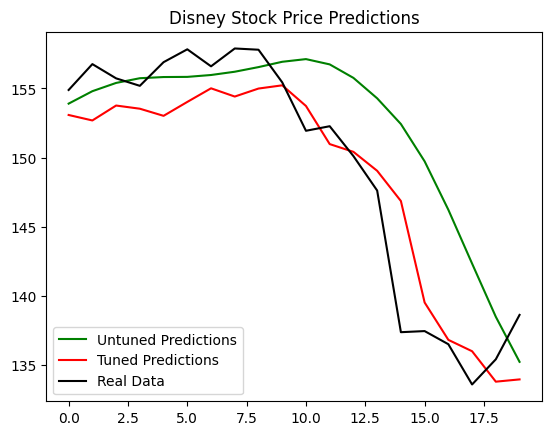

In [135]:
plt.plot(unscaled_predictions_m, color = 'green', label = "Untuned Predictions")
plt.plot(unscaled_predictions_m_t, color = 'red', label = "Tuned Predictions")
plt.plot(x_test_month, color = 'black', label = "Real Data")
plt.title('Disney Stock Price Predictions')
plt.legend()

<b>Table of Results

In [136]:
results_df

,MSE,r2
Untuned RNN (Training),26.396895,0.936937
Untuned RNN (month prediction),35.471389,0.541892
Tuned RNN (Training),13.196500,0.968473
Tuned RNN (month prediction),10.496732,0.864436
